In [1077]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [1078]:
df = pd.read_csv('day.csv')
tp = df.copy()
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [1079]:
df.shape

(730, 16)

In [1080]:
#these variables are of less use in terms of EDA and model building
del df['dteday']
del df['instant']

## EDA

In [1081]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 80.0 KB


There seems to be no null values in the dataset, so we can proceed with Data analysis

In [1082]:
#categorical variables are converted from integers to strings
df.mnth = df.mnth.map({1:'Jan', 2:'Feb', 3:'March', 4:'April', 5:'May', 6:'June',
            7:'July', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
df.weekday = df.weekday.map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'})
df.season = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df.weathersit = df.weathersit.map({1:'weathersit 1', 2:'weathersit 2', 3:'weathersit 3', 4:'weathersit 4'})
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,Jan,0,Monday,1,weathersit 2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,Jan,0,Tuesday,1,weathersit 2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,Jan,0,Wednesday,1,weathersit 1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,Jan,0,Thursday,1,weathersit 1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,Jan,0,Friday,1,weathersit 1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


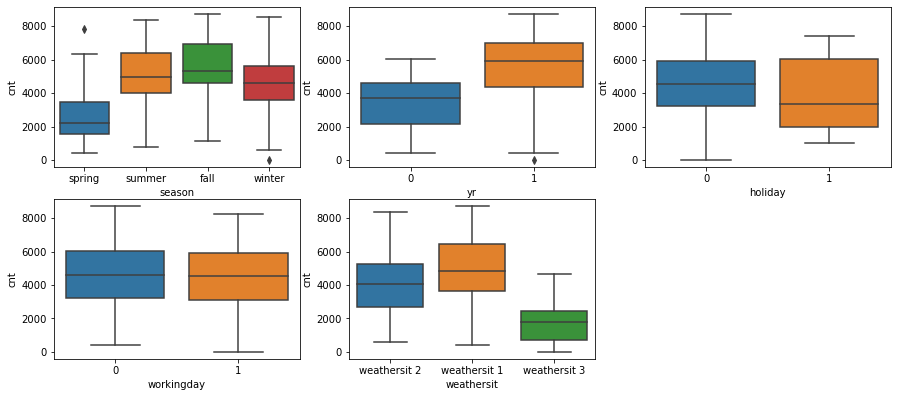

In [1083]:
#ploting boxplot of categorical variables against target variable cnt
categorical_vars = ['season', 'yr', 'holiday', 'workingday', 'weathersit']
plt.figure(figsize=(15,10))
for i in range(1,len(categorical_vars) + 1):
    plt.subplot(3,3,i)
    sns.boxplot(data= df, x=categorical_vars[i-1], y='cnt')

Inferences:
- People generally doesnt prefer spring for bikes
- We see wide range of people using bikes during normal days i.e., people don't prefer renting bikes during holidays
- There is similar range of people renting bikes irrespective of working or non working day
- People prefer clear sky when renting bikes (weathersit 1 and 2) compared to even light rain (weathersit 3)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

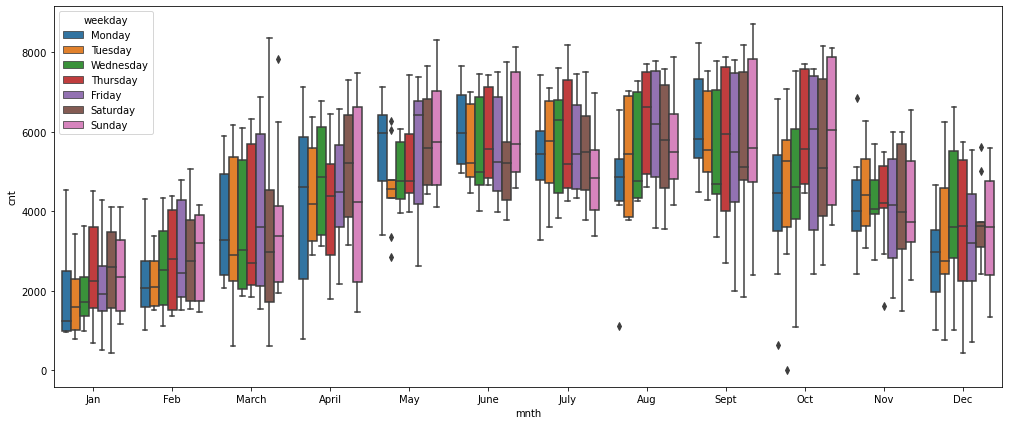

In [1084]:
#segmented boxplot of month variable and target variable cnt segmented by the day of the week
plt.figure(figsize=(17,7))
sns.boxplot(data=df, x='mnth', y='cnt', hue='weekday')

Inferences:
- There is a general spike of rentals during the months April to September
- There is wide range of people prefering bikes during the weekends from April to September, they might rent bikes to exercise
- There is very less bike rentals during January and Feburary since the weather might be cold or even snowing which is not ideal for riding bikes
- From the month November to Feburary, bike rentals counts is low on weekends almost similar to weekdays, where the weather might be the reason

<AxesSubplot:>

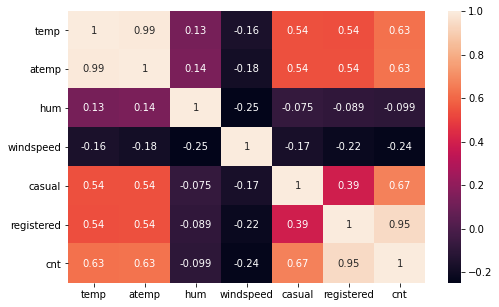

In [1085]:
#heatmap of numerical variables to find colinearity among themselves
plt.figure(figsize=(8,5))
sns.heatmap(df[['temp', 'atemp', 'hum', 'windspeed', 'casual','registered', 'cnt']].corr(), annot= True)

- We see very high positive correlation between **temp** and **atemp**, so removing any one of them is important
- **Casual** and **Registered** equally contribute to the target variabele, so removing both is necessary

In [1086]:
#dropping the variables from the dataset since they are highly colinear wiht others
df.drop(['atemp', 'casual', 'registered'], axis= 1, inplace= True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Monday,1,weathersit 2,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tuesday,1,weathersit 2,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wednesday,1,weathersit 1,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thursday,1,weathersit 1,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Friday,1,weathersit 1,9.305237,43.6957,12.522300,1600


### Data Preparation

In [1087]:
#creating dummy variables for categorical variables have more than two categories in single column
dummies = pd.get_dummies(df[['season', 'mnth', 'weekday', 'weathersit']], drop_first= True)
dummies.head()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,mnth_March,...,mnth_Oct,mnth_Sept,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_weathersit 2,weathersit_weathersit 3
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1088]:
#merging the dummies with the original data
df = pd.concat([df, dummies], axis= 1)
#dropping the original variables upon which the dummies are created
df.drop(['season', 'mnth', 'weekday', 'weathersit'], axis = 1, inplace= True)
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_weathersit 2,weathersit_weathersit 3
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1089]:
#Train and test split: 70:30 split
y = df.pop('cnt')
X = df
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size= 0.7, random_state= 15)
print(Xtrain.shape)
print(ytrain.shape)

(510, 28)
(510,)


In [1090]:
print(Xtest.shape)
print(ytest.shape)

(220, 28)
(220,)


### Model Building

In [1091]:
def linearRegression(data):
    #a column with ones are added to the dataset
    X = sm.add_constant(data)
    y = ytrain
    
    #Finding the VIF of the columns
    VIF = pd.DataFrame()
    VIF['features'] = data.columns
    VIF['VIF'] = [variance_inflation_factor(data.values, x) for x in range(data.shape[1])]
    VIF.VIF = round(VIF.VIF, 2)
    VIF =  VIF.sort_values(by= 'VIF', ascending= False)
    return sm.OLS(y, X).fit(), VIF

In [1092]:
#this function returns the selected features from the entire feature set by returning the selected variable set
#by giving the number of features as input
def featureRanking(l):
    lm = LinearRegression()
    lm.fit(Xtrain, ytrain)

    rfe = RFE(lm, l)
    rfe = rfe.fit(Xtrain, ytrain)
    rnks = pd.DataFrame({'columns': Xtrain.columns,
                         'support': rfe.support_,
                         'ranks': rfe.ranking_})
    var = list(rnks[rnks.ranks == 1]['columns'].values)
    return var

In [1093]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [1094]:
v = ['temp', 'hum', 'windspeed']
Xtrain[v] = scaler.fit_transform(Xtrain[v]) #fits on train dataset and transforms it
Xtest[v] = scaler.transform(Xtest[v]) #transforms the test data using the train dataset as reference

In [1095]:
ytrain = scaler.fit_transform(ytrain.values.reshape(-1,1)) #scales the target
ytest = scaler.transform(ytest.values.reshape(-1,1))

In [1096]:
var = featureRanking(16)
lm, VIF = linearRegression(Xtrain[var])
print(lm.summary())
print(VIF)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     175.8
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          7.35e-192
Time:                        20:44:02   Log-Likelihood:                -238.37
No. Observations:                 510   AIC:                             510.7
Df Residuals:                     493   BIC:                             582.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The model above has 16 features selected, but the p-values of some of the variables are above 0.05, so we can reduce the no of features to 15 and check if it passes.

In [1097]:
var = featureRanking(15)
lm, VIF = linearRegression(Xtrain[var])
print(lm.summary())
print(VIF)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     187.0
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          1.59e-192
Time:                        20:44:02   Log-Likelihood:                -239.51
No. Observations:                 510   AIC:                             511.0
Df Residuals:                     494   BIC:                             578.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

This model with 15 features has all variables with p-values below 0.05 and VIF lesser than 5 <br>
the adjusted r-squared value is: 0.846

### Model Assesment

In [1098]:
Xtest2 = sm.add_constant(Xtest[var])
ytest_pred = lm.predict(Xtest2).values.reshape(-1,1)

In [1099]:
r2 = r2_score(ytest_pred, ytest)
adjusted_r2 = 1 - (((1 - r2) * (len(ytest) - 1)) / (len(ytest) - len(var) - 1))
print('The r-squared value of test data is: ', r2)
print('The adjusted r-squared value of test data is: ', adjusted_r2)

The r-squared value of test data is:  0.7845401888954743
The adjusted r-squared value of test data is:  0.7686975557260238


In [1100]:
xt = sm.add_constant(Xtrain[var])
ytrain_pred = lm.predict(xt)
print('The root mean squared error of train data is: ', np.sqrt(mean_squared_error(ytrain, ytrain_pred)))

The root mean squared error of train data is:  0.3870090420481544


In [1101]:
print('The root mean squared error of train data is: ', np.sqrt(mean_squared_error(ytest, ytest_pred)))

The root mean squared error of train data is:  0.4504750497045497


<AxesSubplot:>

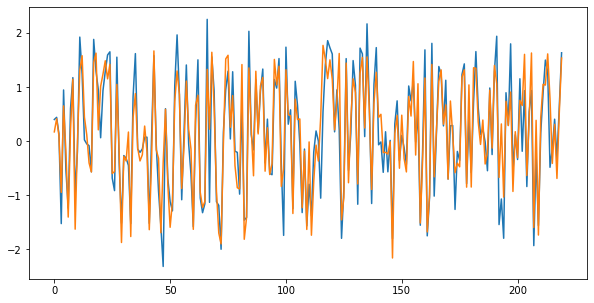

In [1102]:
plt.figure(figsize=(10,5))
sns.lineplot(range(len(ytest)),ytest[:,0])
sns.lineplot(range(len(ytest)),ypred[:,0])

The line plot of predictive and train targets are mostly similar, which means that the model is good

<AxesSubplot:ylabel='Density'>

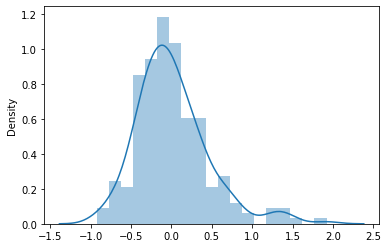

In [1103]:
res = ypred - ytest
sns.distplot(res)

The residuals are normal distributed with zero in center

### Final Model

In [1104]:
#model's co-efficients and intercept
lm.params

const                     -0.274614
yr                         1.053991
holiday                   -0.271486
temp                       0.447942
hum                       -0.132575
windspeed                 -0.121921
season_spring             -0.413348
season_winter              0.398234
mnth_Dec                  -0.365748
mnth_Feb                  -0.205125
mnth_Jan                  -0.297539
mnth_July                 -0.217237
mnth_Nov                  -0.324598
mnth_Sept                  0.253585
weathersit_weathersit 2   -0.188920
weathersit_weathersit 3   -0.933530
dtype: float64

The final model has the straight line formula as:<br><br>
\begin{equation*}
Y = -0.274 + yr * 1.053 + holiday * -0.2714 + temp * 0.447 + hum * -0.13 + windspeed * -.121 + spring * 0.413 + winter * 0.398 + december * -0.365+ feb * -0.205 + jan * -0.297 + july * -0.217 + nov * -0.324 + sept * 0.253 + weathersit2 * -0.188 + weathersit3 * -0.933
\end{equation*}

Important Variables:
- temperature
- holiday
- Months between April and June
- Weathersit 1 (Clear, Few clouds, Partly cloudy)

The main driver variables:
- **temp**: warmer the temperature more people rent bikes
- **Weathersit 1 (Clear, Few clouds, Partly cloudy)**: more bikes are rented when the skies are clear with fewer clouds
- **Holiday**: During holidays there is less bike rentals because we can guess that people often rent bikes to travel to their workplace and some people doesnt want to spend biking during holidays

Final Insights:
- There are high rentals during summer season
- People generally prefer clear skies for rentals
- There is high demand in 2019 than 2018
- If the temperature is warmer we can expect more rentals